In [ ]:
# This block imports modules, randomly separates the data into training / validation / test sets, 
# and defines and evaluates the pretrained model

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.version
from torchvision.models import resnet34
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.utils import make_grid

# This implementation includes a scipy library to directly read .WAV files and uses TorchAudio for structure and transforms


import os
from scipy.io import wavfile
import torchaudio
import torchaudio.transforms as transforms
import soundfile
from torch.nn.utils.rnn import pad_sequence

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # set device to GPU if available
#print(torch.version.cuda)
#print(device)

class AudioDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir # "data/" directory location
        self.file_paths = [] # file path for each data point
        self.labels = [] # list of labels in dataset
        self.transform = transform # transform (if specified - converts to Mel spectrogram in implementation)

        # Import data from files, using path for class folder as label identifier
        for label in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label)
            if os.path.isdir(label_path):
                for file_name in os.listdir(label_path):
                    if file_name.endswith(".wav"):
                        self.file_paths.append(os.path.join(label_path, file_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load the audio file
        audio_path = self.file_paths[idx]
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert to mono if it's stereo
        if waveform.size(0) > 1:  # Check if stereo
            waveform = waveform.mean(dim=0, keepdim=True)  # Average channels

        # Get the label
        label = self.labels[idx]
        
        # Apply transformation if specified
        if self.transform:
            waveform = self.transform(waveform)
        
        return waveform.squeeze(0), label

class AudioDataset_WithPadding(Dataset):
    def __init__(self, root_dir, max_length, transform=None):
        self.root_dir = root_dir # "data/" directory location
        self.file_paths = [] # file path for each data point
        self.labels = [] # list of labels in dataset
        self.max_length = max_length # Uses maximum audio file length found when first loading dataset to determine padding length
        self.transform = transform # transform (if specified - converts to Mel spectrogram in implementation)

        # Import data from files, using path for class folder as label identifier
        for label in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label)
            if os.path.isdir(label_path):
                for file_name in os.listdir(label_path):
                    if file_name.endswith(".wav"):
                        self.file_paths.append(os.path.join(label_path, file_name))
                        self.labels.append(label)

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        # Load the audio file
        audio_path = self.file_paths[idx]
        waveform, sample_rate = torchaudio.load(audio_path)

        # Convert to mono if necessary
        if waveform.size(0) > 1:  # Check if stereo
            waveform = waveform.mean(dim=0, keepdim=True)  # Average channels

        # Pad waveform to the fixed length
        if waveform.size(1) < self.max_length:
            pad_amount = self.max_length - waveform.size(1)
            #print(pad_amount)
            waveform = torch.nn.functional.pad(waveform, (0, pad_amount), "constant", 0)
        
        # Get the label
        label = self.labels[idx]
        if label == "Major":
            label_num = 0
        else:
            label_num = 1
        
        # Apply transformation if specified
        if self.transform:
            waveform = self.transform(waveform)
            #print(waveform.size(2))

        return waveform, label, label_num


transform = transforms.MelSpectrogram(sample_rate=16000, n_mels=64)

root_dir = "data/"

dataset_temp = AudioDataset(root_dir) # Create dataset from major / minor chords folders (chords are organized in folders by chord type)

waveforms = [dataset_temp[i][0] for i in range(len(dataset_temp))]

max_length = 0
for i, waveform in enumerate(waveforms):
    if (int(waveform.shape[0])) > max_length:
        max_length = int(waveform.shape[0])

dataset = AudioDataset_WithPadding(root_dir, max_length=max_length, transform=transform) # Create dataset from major / minor chords folders (chords are organized in folders by chord type)

waveforms = [dataset[i][0] for i in range(len(dataset))]

data_loader = torch.utils.data.DataLoader(dataset, batch_size = 1, shuffle=True) # Load Dataset

for batch in data_loader:
    waveforms, labels, labels_num = batch

num_data = len(dataset) # Total Number of Data Points in Dataset

train_size = int(0.7*num_data) # Allocate 70% of Data Points for Training
val_size = int(0.15*num_data) # Allocate 15% of Data Points for Validation Set
test_size = num_data - train_size - val_size # Allocate Remaining Data Points (15%) for Test Set

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size]) # Use random_split to randomly separate the dataset into training, validation, testing sets

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True) # training data loader with randomization and batch size 10
val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False) # validation data loader with no randomization and batch size 10
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False) # test data loader with no randomization and batch size 10

num_class = 2
model_pretrained = resnet34(pretrained=True)
model_pretrained.fc = nn.Sequential(
    nn.Dropout(0.5), # implement dropout rate of 50% to discourage overfitting
    nn.Linear(model_pretrained.fc.in_features, num_class)
)

model_pretrained.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)

num_major = 0
num_minor = 0

# Get count of major / minor chords in training set

for waveform, label, label_num in train_dataset:
    if label_num == 0:
        num_major += 1
    else:
        num_minor += 1

class_ns = torch.tensor([num_major, num_minor])
weights = 1.0 / class_ns
weights = weights / weights.sum()

criter = nn.CrossEntropyLoss(weight=weights)

model_pretrained.to(device) # move pretrained model to GPU

def visualize_hook(module, input, output):
    activation = output.squeeze(0) # find activations of layer, remove zeroes
    activation = activation.unsqueeze(1) # remove ones from activation tensor to match image characteristics

    grid = make_grid(activation, nrow=8, normalize=True, scale_each = True) # create grid using make_grid from activations
    
    plt.figure(figsize=(15, 15))
    for i in range(output.size(1)):
        #plt.subplot(8, 8, i + 1)
        plt.imshow(grid.permute(1,2,0).cpu().numpy(), cmap="gray") # show image with grid in grayscale
        #plt.imshow(output[0,i].detach().cpu().numpy(), cmap="gray")
        plt.axis("off")
    plt.show()


model_pretrained.eval()

outputs_list = []
correct = 0
total = 0
loss_pretrained = 0
with torch.no_grad():
    for waveforms, labels, labels_num in test_loader:
        waveforms, labels_num = waveforms.to(device), labels_num.to(device)
        #images, labels = images.to(device), labels.to(device)
        #print(images.shape)
        outputs = model_pretrained(waveforms)
        _, predicted = torch.max(outputs, 1)
        total+= len(labels)
        #batch_labels = []
        for i in range(len(labels_num)):
            if labels_num[i] == predicted[i]:
                correct+=1
        #print(batch_labels)
        #correct+= (predicted == batch_labels).sum().item()
        outputs_list.append(outputs)
        #batch_labels = torch.tensor(batch_labels)
        #print(batch_labels)
        loss = criter(outputs,labels_num)
        loss_pretrained += loss.item() * waveforms.size(0)
        

print("{}% Test Accuracy With Pre-Trained Model".format(correct/total*100))
print("Test Set Loss of {} With Pre-Trained Model".format(loss_pretrained))




C:\Users\sk3ll\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sk3ll\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


56.15384615384615% Test Accuracy With Pre-Trained Model
Test Set Loss of 226.1627161502838 With Pre-Trained Model


Training Model with Fully Connected (Output) Layer Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.8284213545913506
Training Accuracy After Epoch 1: 48.92%

Validation Loss For Epoch 1: 0.7774164713919163
Validation Accuracy After Epoch 1: 52.34%

Epoch 2/10:

Training Loss For Epoch 2: 0.7827388231647193
Training Accuracy After Epoch 2: 51.41%

Validation Loss For Epoch 2: 0.7928068116307259
Validation Accuracy After Epoch 2: 43.75%

Epoch 3/10:

Training Loss For Epoch 3: 0.8072377367444126
Training Accuracy After Epoch 3: 50.75%

Validation Loss For Epoch 3: 0.7702147886157036
Validation Accuracy After Epoch 3: 54.69%

Epoch 4/10:

Training Loss For Epoch 4: 0.8165724955858684
Training Accuracy After Epoch 4: 49.25%

Validation Loss For Epoch 4: 0.7977264635264874
Validation Accuracy After Epoch 4: 53.12%

Epoch 5/10:

Training Loss For Epoch 5: 0.7906989055048804
Training Accuracy After Epoch 5: 52.58%

Validation Loss For Epoch 5: 0.8178689852356911
Validation Accuracy After 

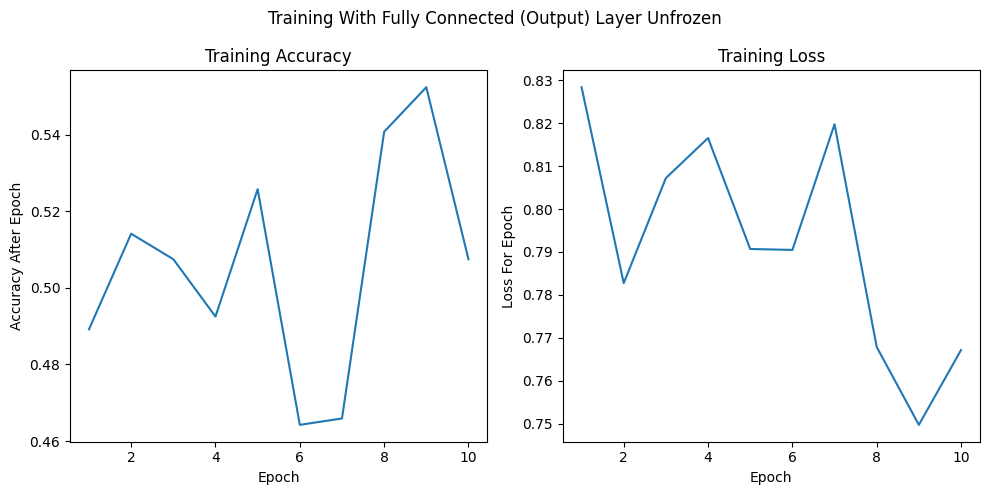

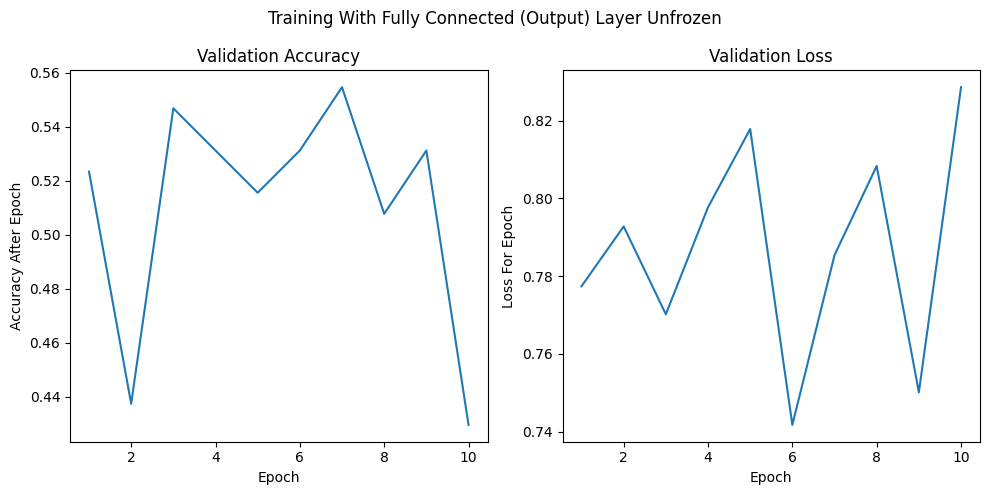

In [3]:
# This block fine-tunes the fully connected output layer of the model, beginning with the pretrained ResNet-34 model

import torch.optim as optim

model = resnet34(pretrained=True) # pre-trained ResNet-34 model
model.fc = nn.Sequential(
    nn.Dropout(0.5), # implement dropout rate of 50% to discourage overfitting
    nn.Linear(model.fc.in_features, num_class)
) # change fully connected output layer to 3 outputs to match class count
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)

model = model.to(device) # move model to GPU

for param in model.parameters(): # freeze all model parameters
    param.requires_grad = False
for param in model.fc.parameters(): # unfreeze fully connected layer
    param.requires_grad = True

criter = nn.CrossEntropyLoss(weight=weights) # Cross-Entropy Loss Function
optimizer = optim.Adam(model.fc.parameters(), lr=1e-4) # Adam optimizer with learning rate 1e-4 to start training

num_epoch = 10 # 10 epochs

def train_model(model, dataloader, criter, optimizer, num_epoch = 5):

    train_acc = [] # list of training accuracies during this training
    train_losses = [] # list of training losses during this training
    val_acc = [] # list of validation accuracies during this training 
    val_losses = [] # list of validation losses during this training
    
    for epoch in range(num_epoch):
        print("Epoch {}/{}:\n".format(epoch+1,num_epoch)) 

        model.train() # set model to training mode
        train_loss = 0 # training loss running total starts at zero
        train_correct = 0 # correctly classified images from training set running total starts at zero
        val_loss = 0 # validation loss running total starts at zero
        val_correct = 0 # correctly classified images from validation set running total starts at zero

        for inputs, labels, labels_num in dataloader["train"]:
            inputs, labels_num = inputs.to(device), labels_num.to(device) # move inputs (images) and labels to GPU

            optimizer.zero_grad()
            outputs = model(inputs) # feed forward
            _, class_preds_train = torch.max(outputs,1) # predict classes based on model output
            loss = criter(outputs,labels_num) # generate loss values

            loss.backward() # backpropagate
            optimizer.step()

            train_loss += loss.item() * inputs.size(0) # add loss from this epoch to training loss
            train_correct += torch.sum(class_preds_train == labels_num.data) # add correctly classified images count to total correctly classified for training set

        train_loss_epoch = train_loss / len(dataloader["train"].dataset) # training loss this epoch
        train_losses.append(train_loss_epoch) # add training loss this epoch to list of training losses
        train_acc_epoch = train_correct / len(dataloader["train"].dataset) # training accuracy this epoch
        train_acc.append(train_acc_epoch) # add training accuracy this epoch to list of training accuracies

        for inputs, labels, labels_num in dataloader["val"]: # performs same loss / accuracy calculations as training set for validation set
            inputs, labels_num = inputs.to(device), labels_num.to(device) 
            
            outputs = model(inputs)
            _, class_preds_val = torch.max(outputs, 1)
            loss = criter(outputs,labels_num)

            # Do not backpropagate - no training on validation set
            
            val_loss += loss.item() * inputs.size(0)
            val_correct += torch.sum(class_preds_val == labels_num.data)

        val_loss_epoch = val_loss / len(dataloader["val"].dataset)
        val_losses.append(val_loss_epoch)
        val_acc_epoch = val_correct / len(dataloader["val"].dataset)
        val_acc.append(val_acc_epoch)

        print("Training Loss For Epoch {}: {}".format(epoch+1, train_loss_epoch))
        print("Training Accuracy After Epoch {}: {:.2f}%\n".format(epoch+1, train_acc_epoch*100))

        print("Validation Loss For Epoch {}: {}".format(epoch+1, val_loss_epoch))
        print("Validation Accuracy After Epoch {}: {:.2f}%\n".format(epoch+1, val_acc_epoch*100))
    
    return model, train_acc, train_losses, val_acc, val_losses
    
print("Training Model with Fully Connected (Output) Layer Unfrozen:\n")
dataloader = {"train": train_loader, "val": val_loader}
model, train_acc, train_losses, val_acc, val_losses = train_model(model, dataloader, criter, optimizer, num_epoch)

def plot_learning(num_epoch, accuracy, loss, layer_description, dataset='Train'):

    if dataset == 'train':
        dataset = "Training"
    if dataset == 'val':
        dataset = "Validation"
    acc_cpu = []
    loss_cpu = []

    # Move accuracy and loss tensors to CPU for numpy use
    for i in range(len(accuracy)):
        acc_cpu.append(accuracy[i].clone().detach().cpu())
        loss_cpu.append(loss[i])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5)) # create two subplots

    x = []
    for i in range(num_epoch):
        x.append(i+1) # Create list for X values from 0 to num_epoch for plotting

    # Plotting Accuracy vs Epoch
    ax1.plot(x, acc_cpu)
    ax1.set_title('{} Accuracy'.format(dataset))
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy After Epoch')

    # Plotting Loss vs Epoch
    ax2.plot(x, loss_cpu)
    ax2.set_title('{} Loss'.format(dataset))
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss For Epoch')

    plt.suptitle(layer_description)
    plt.tight_layout()

    plt.show()
    
layer_description = "Training With Fully Connected (Output) Layer Unfrozen"
plot_learning(num_epoch, train_acc, train_losses, layer_description, dataset="train")
plot_learning(num_epoch, val_acc, val_losses, layer_description, dataset="val")

Training Model with Fully Connected (Output) Layer and Layer 4 Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.7240155641231283
Training Accuracy After Epoch 1: 60.73%

Validation Loss For Epoch 1: 0.8964530741795897
Validation Accuracy After Epoch 1: 50.00%

Epoch 2/10:

Training Loss For Epoch 2: 0.5830595274634052
Training Accuracy After Epoch 2: 70.72%

Validation Loss For Epoch 2: 0.7460700976662338
Validation Accuracy After Epoch 2: 56.25%

Epoch 3/10:

Training Loss For Epoch 3: 0.4272356902105043
Training Accuracy After Epoch 3: 80.20%

Validation Loss For Epoch 3: 0.693961251527071
Validation Accuracy After Epoch 3: 63.28%

Epoch 4/10:

Training Loss For Epoch 4: 0.3796488474093737
Training Accuracy After Epoch 4: 82.70%

Validation Loss For Epoch 4: 0.8855463336221874
Validation Accuracy After Epoch 4: 69.53%

Epoch 5/10:

Training Loss For Epoch 5: 0.26857091542240386
Training Accuracy After Epoch 5: 88.02%

Validation Loss For Epoch 5: 1.01054414967075
Validation Accur

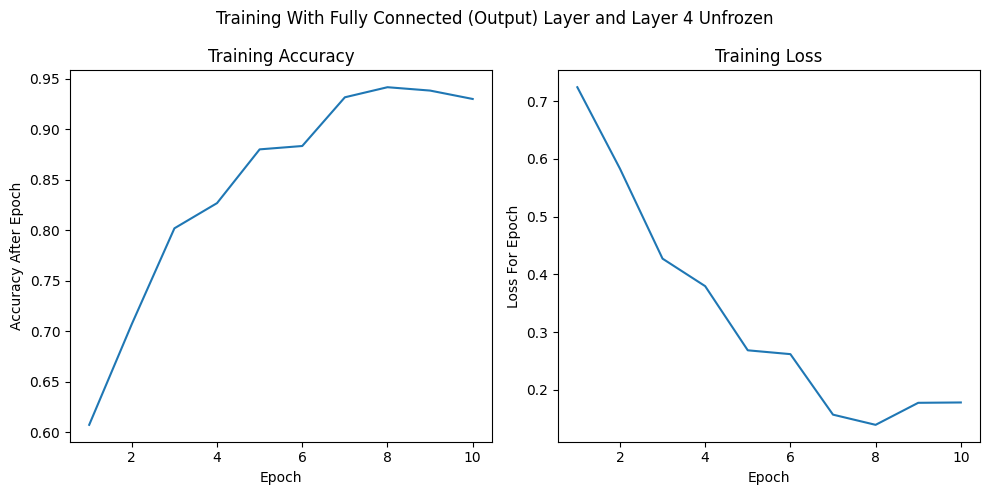

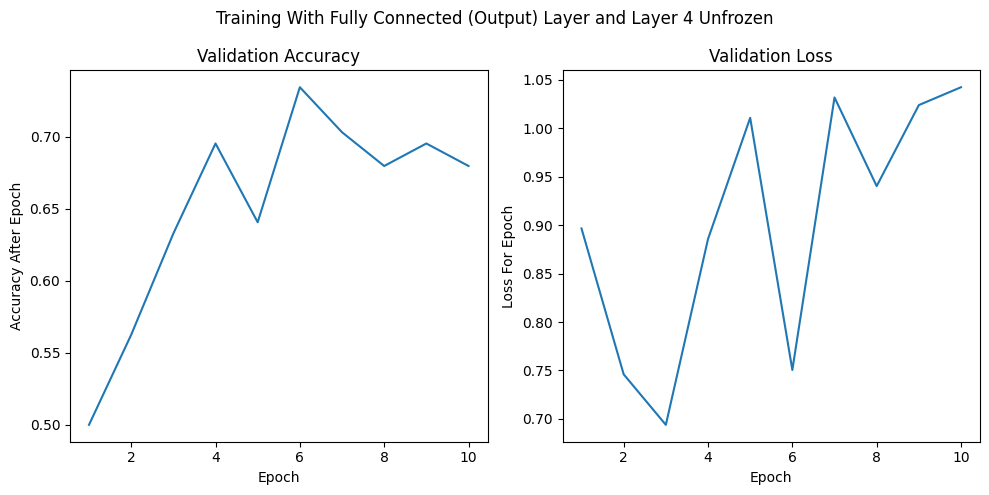

In [4]:
# This block fine-tunes layer 4 of the model

optimizer = optim.Adam(model.parameters(), lr=1e-4)

for param in model.parameters():
    param.requires_grad = False
for param in model.layer4.parameters(): # Unfreeze Layer 4 in this block
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

print("Training Model with Fully Connected (Output) Layer and Layer 4 Unfrozen:\n")

model, layer4_train_acc, layer4_train_losses, layer4_val_acc, layer4_val_losses = train_model(model, dataloader, criter, optimizer, num_epoch)

layer_description = "Training With Fully Connected (Output) Layer and Layer 4 Unfrozen"
plot_learning(num_epoch, layer4_train_acc, layer4_train_losses, layer_description, dataset="train")
plot_learning(num_epoch, layer4_val_acc, layer4_val_losses, layer_description, dataset="val")

Training Model with Fully Connected (Output) Layer, Layer 4, Layer 3 Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.1076534070096253
Training Accuracy After Epoch 1: 96.67%

Validation Loss For Epoch 1: 0.9864554291125387
Validation Accuracy After Epoch 1: 74.22%

Epoch 2/10:

Training Loss For Epoch 2: 0.06041987375906373
Training Accuracy After Epoch 2: 98.17%

Validation Loss For Epoch 2: 0.9912599138915539
Validation Accuracy After Epoch 2: 72.66%

Epoch 3/10:

Training Loss For Epoch 3: 0.07832525139628056
Training Accuracy After Epoch 3: 97.00%

Validation Loss For Epoch 3: 0.9073198847472668
Validation Accuracy After Epoch 3: 72.66%

Epoch 4/10:

Training Loss For Epoch 4: 0.05288455947170564
Training Accuracy After Epoch 4: 98.50%

Validation Loss For Epoch 4: 0.9203832547646016
Validation Accuracy After Epoch 4: 74.22%

Epoch 5/10:

Training Loss For Epoch 5: 0.03034460760448469
Training Accuracy After Epoch 5: 99.67%

Validation Loss For Epoch 5: 0.8747377288527787
Vali

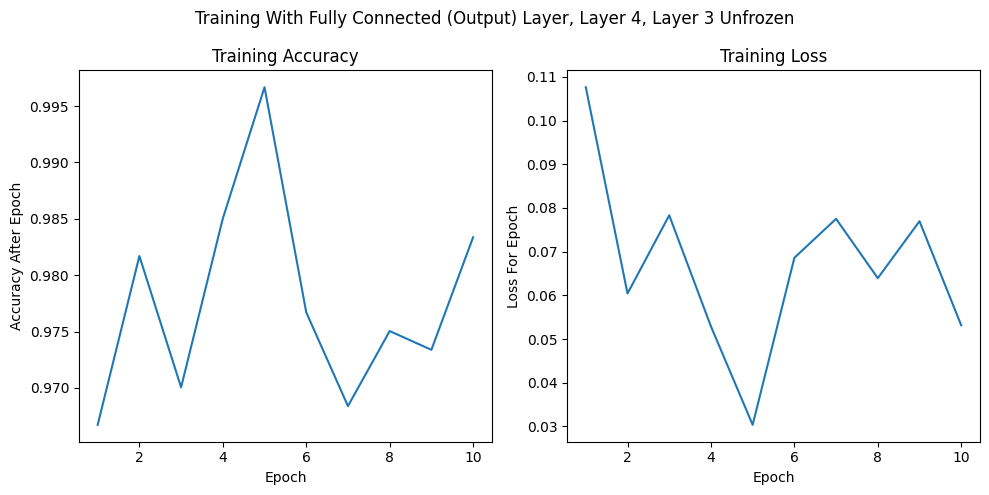

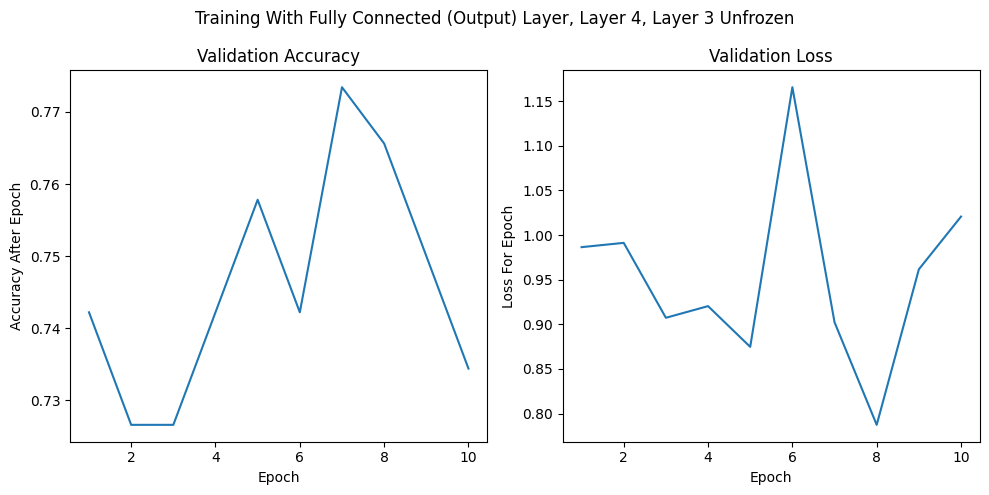

In [5]:
# This block fine-tunes layer 3 of the model

optimizer = optim.Adam(model.parameters(), lr=1e-5) # Lower learning rate from 1e-4 to 1e-5 as learning plateaus

for param in model.parameters():
    param.requires_grad = False
for param in model.layer3.parameters(): # Unfreeze layer 3 in this block
    param.requires_grad = True
for param in model.layer4.parameters(): 
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

print("Training Model with Fully Connected (Output) Layer, Layer 4, Layer 3 Unfrozen:\n")

model, layer3_train_acc, layer3_train_losses, layer3_val_acc, layer3_val_losses = train_model(model, dataloader, criter, optimizer, num_epoch)

layer_description = "Training With Fully Connected (Output) Layer, Layer 4, Layer 3 Unfrozen"
plot_learning(num_epoch, layer3_train_acc, layer3_train_losses, layer_description, dataset="train")
plot_learning(num_epoch, layer3_val_acc, layer3_val_losses, layer_description, dataset="val")

Training Model with Fully Connected (Output) Layer, Layer 4, Layer 3, Layer 2 Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.04058969996059112
Training Accuracy After Epoch 1: 98.67%

Validation Loss For Epoch 1: 0.8677238295786083
Validation Accuracy After Epoch 1: 78.91%

Epoch 2/10:

Training Loss For Epoch 2: 0.07519827695050511
Training Accuracy After Epoch 2: 97.17%

Validation Loss For Epoch 2: 0.865505026478786
Validation Accuracy After Epoch 2: 74.22%

Epoch 3/10:

Training Loss For Epoch 3: 0.06459331361169364
Training Accuracy After Epoch 3: 97.67%

Validation Loss For Epoch 3: 0.9918526650872082
Validation Accuracy After Epoch 3: 77.34%

Epoch 4/10:

Training Loss For Epoch 4: 0.037802123534376925
Training Accuracy After Epoch 4: 99.00%

Validation Loss For Epoch 4: 0.9402927027549595
Validation Accuracy After Epoch 4: 75.00%

Epoch 5/10:

Training Loss For Epoch 5: 0.047202723219327496
Training Accuracy After Epoch 5: 98.67%

Validation Loss For Epoch 5: 1.0766277295

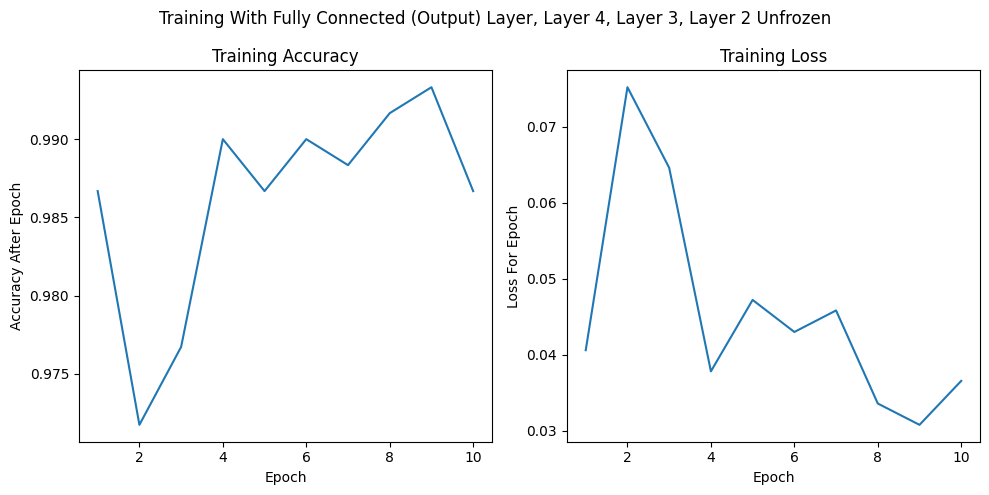

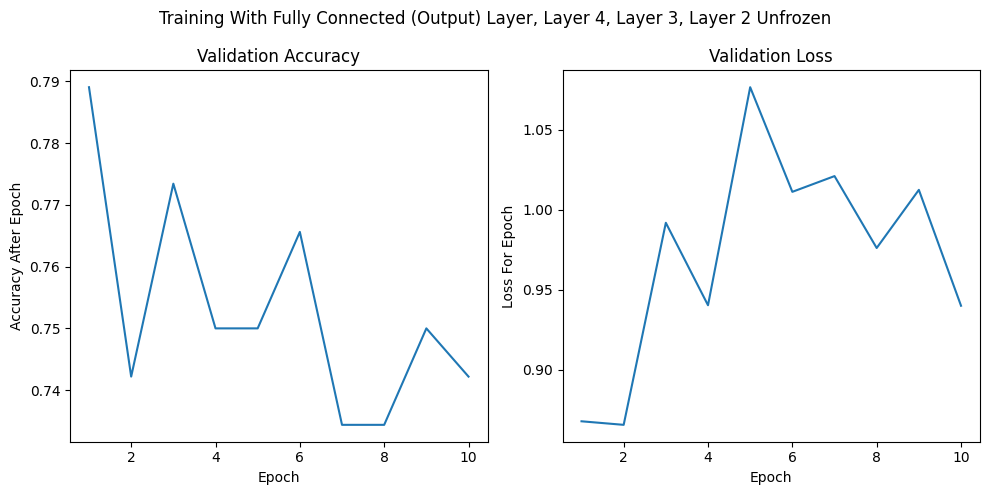

In [6]:
# This block fine-tunes layer 2 of the model

optimizer = optim.Adam(model.parameters(), lr=1e-5) # Lower learning rate from 1e-4 to 1e-5 as learning plateaus

for param in model.parameters():
    param.requires_grad = False
for param in model.layer2.parameters(): # Unfreeze layer 2 in this block
    param.requires_grad = True
for param in model.layer3.parameters(): 
    param.requires_grad = True
for param in model.layer4.parameters(): 
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

print("Training Model with Fully Connected (Output) Layer, Layer 4, Layer 3, Layer 2 Unfrozen:\n")

model, layer2_train_acc, layer2_train_losses, layer2_val_acc, layer2_val_losses = train_model(model, dataloader, criter, optimizer, num_epoch)

layer_description = "Training With Fully Connected (Output) Layer, Layer 4, Layer 3, Layer 2 Unfrozen"
plot_learning(num_epoch, layer2_train_acc, layer2_train_losses, layer_description, dataset="train")
plot_learning(num_epoch, layer2_val_acc, layer2_val_losses, layer_description, dataset="val")

Training Model with Fully Connected (Output) Layer, Layer 4, Layer 3, Layer 2, Layer 1 Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.03829124935390505
Training Accuracy After Epoch 1: 98.67%

Validation Loss For Epoch 1: 0.9813241458614357
Validation Accuracy After Epoch 1: 74.22%

Epoch 2/10:

Training Loss For Epoch 2: 0.02201992474277868
Training Accuracy After Epoch 2: 99.50%

Validation Loss For Epoch 2: 1.0274844159721397
Validation Accuracy After Epoch 2: 75.78%

Epoch 3/10:

Training Loss For Epoch 3: 0.04316884499432956
Training Accuracy After Epoch 3: 98.84%

Validation Loss For Epoch 3: 1.0702943461947143
Validation Accuracy After Epoch 3: 74.22%

Epoch 4/10:

Training Loss For Epoch 4: 0.05613171300980977
Training Accuracy After Epoch 4: 97.84%

Validation Loss For Epoch 4: 1.0002016858197749
Validation Accuracy After Epoch 4: 73.44%

Epoch 5/10:

Training Loss For Epoch 5: 0.05832933583343324
Training Accuracy After Epoch 5: 98.17%

Validation Loss For Epoch 5: 1.10

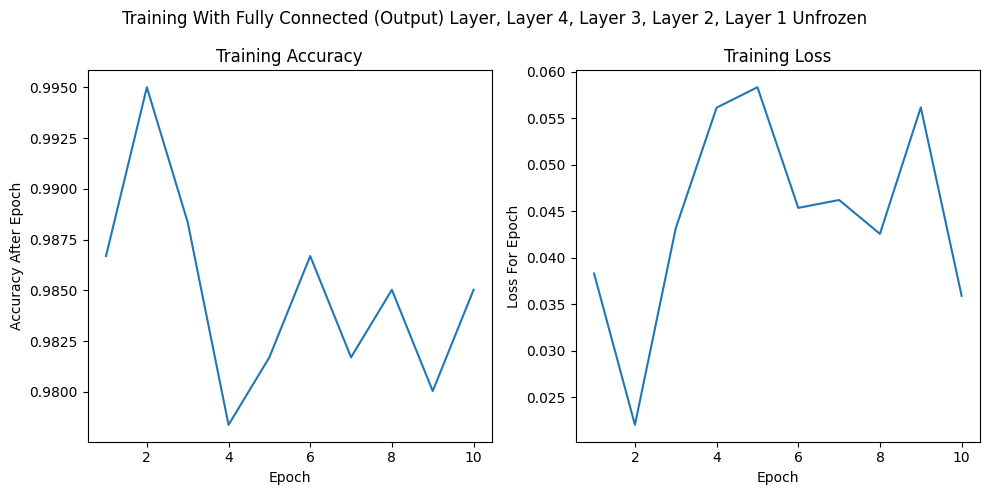

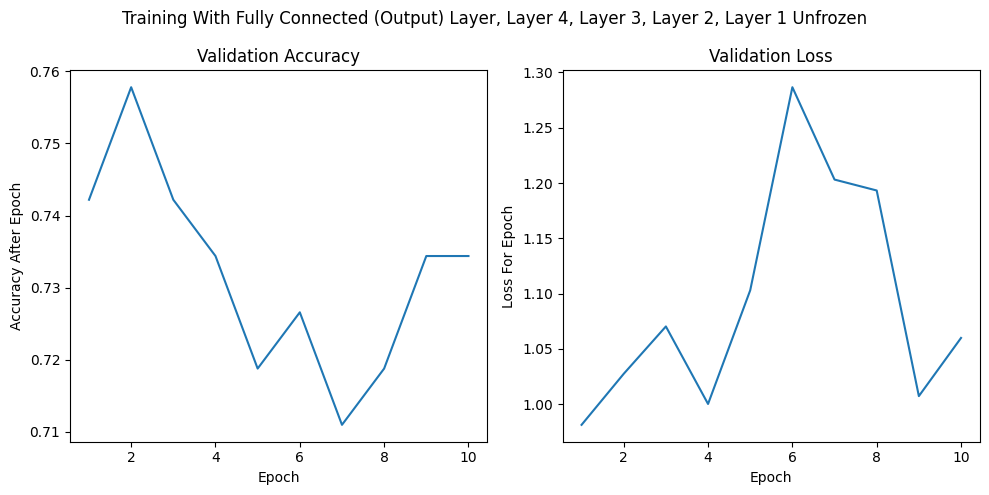

In [7]:
# This block fine-tunes layer 1 of the model

optimizer = optim.Adam(model.parameters(), lr=1e-5) # Lower learning rate from 1e-4 to 1e-5 as learning plateaus

for param in model.parameters():
    param.requires_grad = False
for param in model.layer1.parameters(): # Unfreeze layer 1 in this block
    param.requires_grad = True
for param in model.layer2.parameters():
    param.requires_grad = True
for param in model.layer3.parameters(): 
    param.requires_grad = True
for param in model.layer4.parameters(): 
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

print("Training Model with Fully Connected (Output) Layer, Layer 4, Layer 3, Layer 2, Layer 1 Unfrozen:\n")

model, layer1_train_acc, layer1_train_losses, layer1_val_acc, layer1_val_losses = train_model(model, dataloader, criter, optimizer, num_epoch)

layer_description = "Training With Fully Connected (Output) Layer, Layer 4, Layer 3, Layer 2, Layer 1 Unfrozen"
plot_learning(num_epoch, layer1_train_acc, layer1_train_losses, layer_description, dataset="train")
plot_learning(num_epoch, layer1_val_acc, layer1_val_losses, layer_description, dataset="val")

Training Model With All Layers Unfrozen:

Epoch 1/10:

Training Loss For Epoch 1: 0.04482738679827357
Training Accuracy After Epoch 1: 98.67%

Validation Loss For Epoch 1: 0.9647127790376544
Validation Accuracy After Epoch 1: 71.88%

Epoch 2/10:

Training Loss For Epoch 2: 0.033608072261657636
Training Accuracy After Epoch 2: 98.84%

Validation Loss For Epoch 2: 0.908728381851688
Validation Accuracy After Epoch 2: 76.56%

Epoch 3/10:

Training Loss For Epoch 3: 0.04060895031956513
Training Accuracy After Epoch 3: 98.67%

Validation Loss For Epoch 3: 0.9666106062941253
Validation Accuracy After Epoch 3: 76.56%

Epoch 4/10:

Training Loss For Epoch 4: 0.02886971472894243
Training Accuracy After Epoch 4: 99.00%

Validation Loss For Epoch 4: 0.9271976317977533
Validation Accuracy After Epoch 4: 76.56%

Epoch 5/10:

Training Loss For Epoch 5: 0.034487204614193016
Training Accuracy After Epoch 5: 99.17%

Validation Loss For Epoch 5: 1.045022075297311
Validation Accuracy After Epoch 5: 73.44%

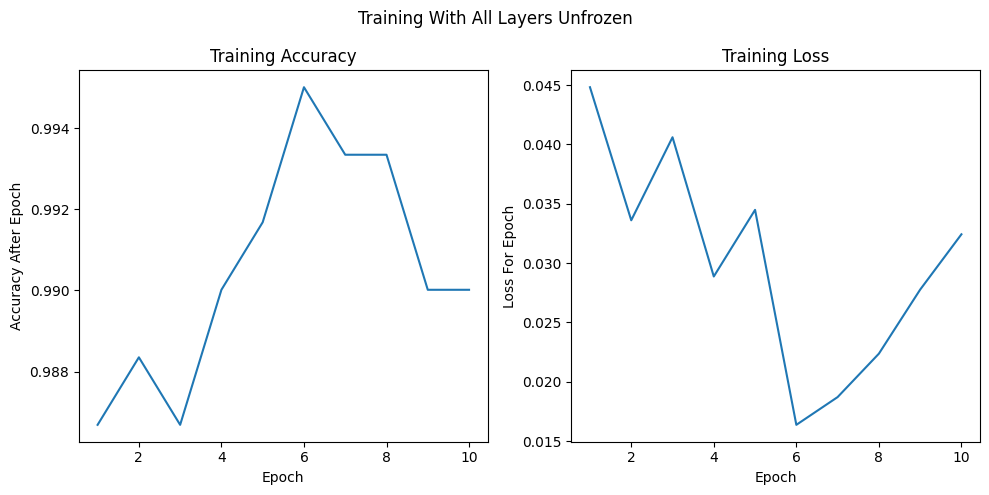

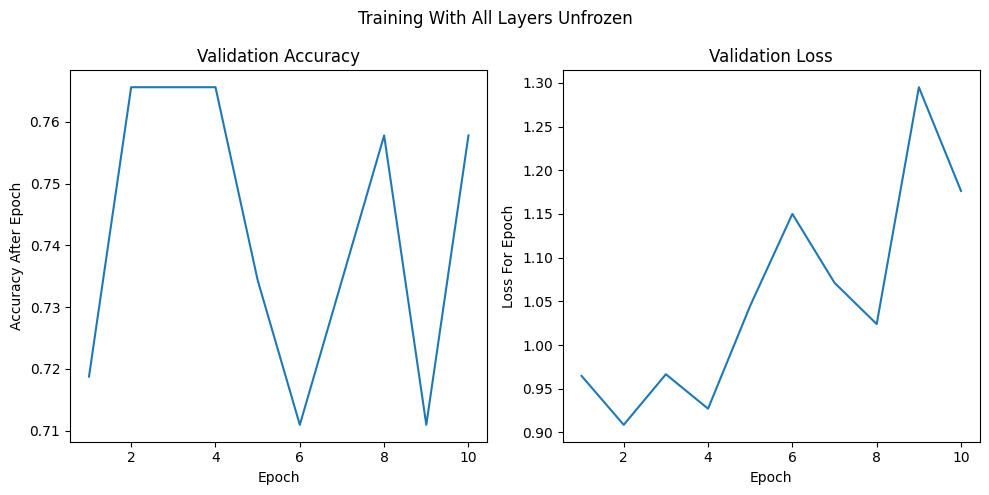

In [8]:
# This block fine-tunes convolutional layer (conv1) of the model

optimizer = optim.Adam(model.parameters(), lr=1e-5) # Lower learning rate from 1e-4 to 1e-5 as learning plateaus

for param in model.parameters(): # Unfreeze all layers to capture all previously unfrozen layers and the final convolutional layer
    param.requires_grad = True

print("Training Model With All Layers Unfrozen:\n")

model, layer_train_acc, layer_train_losses, layer_val_acc, layer_val_losses = train_model(model, dataloader, criter, optimizer, num_epoch)

layer_description = "Training With All Layers Unfrozen"
plot_learning(num_epoch, layer_train_acc, layer_train_losses, layer_description, dataset="train")
plot_learning(num_epoch, layer_val_acc, layer_val_losses, layer_description, dataset="val")

In [9]:
# This block performs analysis and comparisons using the final newly trained model

model.eval()

output_list = []
correct = 0
total = 0
loss_trained = 0
with torch.no_grad():
    for waveforms, labels, labels_num in test_loader:
        waveforms, labels_num = waveforms.to(device), labels_num.to(device)
        outputs = model(waveforms)
        _, predicted = torch.max(outputs, 1)
        total+= labels_num.size(0)
        correct+= (predicted == labels_num).sum().item()
        output_list.append(outputs)
        loss = criter(outputs,labels_num)
        loss_trained += loss.item() * waveforms.size(0)
        

print("{}% Test Accuracy With Newly Trained Model".format(correct/total*100))
print("Test Set Loss of {} With Newly Trained Model".format(loss_trained))



75.38461538461539% Test Accuracy With Newly Trained Model
Test Set Loss of 111.25415354967117 With Newly Trained Model


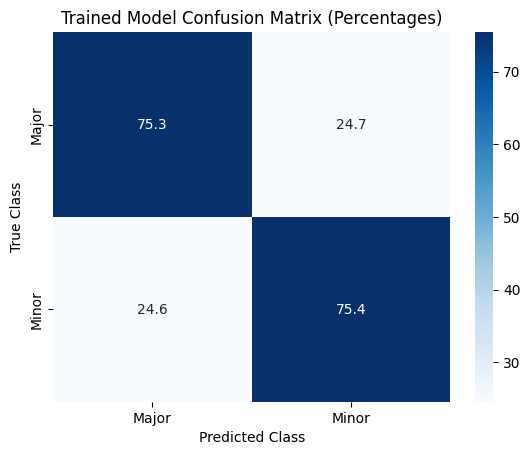

              precision    recall  f1-score   support

       Major       0.80      0.75      0.77        73
       Minor       0.70      0.75      0.73        57

    accuracy                           0.75       130
   macro avg       0.75      0.75      0.75       130
weighted avg       0.76      0.75      0.75       130



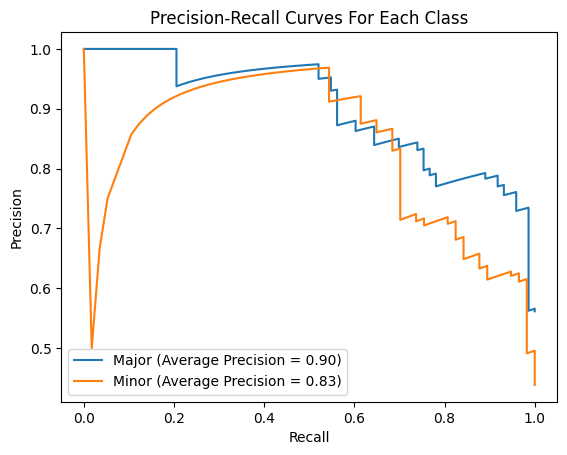

In [ ]:
# This block generates the confusion matrix, classification report, and plots the PR curves for each class

from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score

model.eval()

class_names = ["Major", "Minor"]

label_prob = [] # list of all predicted classes probabilities
label_true = [] # list of true class labels
label_pred = [] # list of predicted class labels

with torch.no_grad():
    for waveforms, labels, labels_num in test_loader:
        waveforms, labels_num = waveforms.to(device), labels_num.to(device)
        outputs = model(waveforms)
        probability = torch.softmax(outputs, dim = 1)
        _, pred = torch.max(outputs,1)

        label_pred.extend(pred)
        label_prob.extend(probability)
        label_true.extend(labels_num)

label_prob = np.array(label_prob)
label_true = np.array(label_true)
label_pred = np.array(label_pred)

model_confusion = confusion_matrix(label_true, label_pred)
model_confusion_percent = model_confusion.astype('float') / model_confusion.sum(axis=1)[:, np.newaxis] * 100

plt.figure()
sns.heatmap(model_confusion_percent, cmap="Blues", annot=True, fmt = '.1f', xticklabels = class_names, yticklabels = class_names)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Trained Model Confusion Matrix (Percentages)")
plt.show()

cr = classification_report(label_true, label_pred, target_names = class_names)
print(cr)

label_true_arr = np.eye(len(class_names))[label_true]

plt.figure()
for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(label_true_arr[:,i], label_prob[:,i])
    average_precision = average_precision_score(label_true_arr[:,i], label_prob[:,i])

    
    plt.plot(recall, precision, label = "{} (Average Precision = {:.2f})".format(class_name, average_precision))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves For Each Class")
plt.legend()
plt.show()